# Making Necessary Imports

In [39]:
import json
import math
import multiprocessing as mp
import os
import pickle
from collections import defaultdict
from functools import partial
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
import spacy
from spacy_langdetect import LanguageDetector
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()
pd.options.mode.chained_assignment = None


In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (LSTM, AdditiveAttention, Bidirectional,
                                     Concatenate, Conv1D, Dense, Embedding,
                                     GlobalMaxPooling1D, Input, Lambda, Layer)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import Sequence, plot_model


# Data processing

## 1. Reading json file

In [23]:
if not os.path.exists('reviews.csv'):
    reviews_file = open('review.txt', 'rb')
    reviews = reviews_file.readlines()
    reviews_file.close()
    reviews_data = {"text": [], "overall": [], "service":[], "cleanliness":[], "value": [], "location": [], "sleep_quality": []}

    for review in tqdm(reviews):
        review_data = json.loads(review)
        reviews_data["text"].append(review_data['text'])
        review_ratings = defaultdict(lambda :0, review_data['ratings'])
        for key in reviews_data.keys():
            if key != 'text':
                reviews_data[key].append(review_ratings[key])

    reviews_df = pd.DataFrame(reviews_data)
    reviews_df.to_csv('reviews.csv', index=False)

reviews_df = pd.read_csv('reviews.csv')
reviews_df.head()

,text,overall,service,cleanliness,value,location,sleep_quality
0,Stayed in a king suite for 11 nights and yes i...,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,4.0,4.0,5.0,4.0,5.0,4.0
3,The Andaz is a nice hotel in a central locatio...,4.0,5.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,4.0,4.0,5.0,3.0,5.0,5.0


## 2. Filtering out non-english reviews

In [ ]:
eng = spacy.load('en_core_web_sm',  disable=['tagger', 'ner'])
eng.add_pipe(LanguageDetector(), name='language_detector', last=True)

review_lang = reviews_df['text'].progress_apply(lambda x: eng(x)._.language)
pickle.dump(review_lang, 'lang.pkl')

In [30]:
if os.path.exists('lang.pkl'):
    lang_file = open('lang.pkl', 'rb')
    review_lang = pickle.load(lang_file)
    lang_file.close()

review_lang[:5]

0    {'language': 'en', 'score': 0.9999965082802036}
1    {'language': 'en', 'score': 0.9999969312742957}
2    {'language': 'en', 'score': 0.9999982183606416}
3    {'language': 'en', 'score': 0.9999964150586057}
4    {'language': 'en', 'score': 0.9999963220075809}
Name: text, dtype: object

In [ ]:
reviews_df = reviews_df[review_lang.map(lambda x: x['language'] == 'en')]

## 3. Removing reviews with length less than 50 and greater than 1000

In [24]:
reviews_len = reviews_df['text'].progress_map(lambda x: len(x.split()))

print(f"Reviews with less than 50 words: {sum(reviews_len<=50)}")
print(f"Reviews with more than 1000 words: {sum(reviews_len>=1000)}")
print(f"Reviews with more than 50 words and less than 1000: {sum((reviews_len>50) & (reviews_len<1000))}")

reviews_df = reviews_df[(reviews_len>50) & (reviews_len<1000)]

  0%|          | 0/878561 [00:00<?, ?it/s]

Reviews with less than 50 words: 136632
Reviews with more than 1000 words: 1257
Reviews with more than 50 words and less than 1000: 740672


## 4. Expanding contractions, removing non-textual data and numbers from the text reviews

In [34]:
# referred this dictionary for contractions expansion: https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python

contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
"didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have",
"he'll": "he shall", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "I had",
"i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it had", "it'd've": "it would have", "it'll": "it will",
"it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
"must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she had", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
"she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that had", "that'd've": "that would have",
"that's": "that is", "there'd": "there had", "there'd've": "there would have", "there's": "there is", "they'd": "they had", "they'd've": "they would have",
"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had", "we'd've": "we would have",
"we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
"who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

In [35]:
def expand_contractions(text):
    words = text.split()
    return ' '.join([x if x.lower() not in contractions else contractions[x.lower()] for x in words])
reviews_df['text'] = reviews_df['text'].progress_apply(expand_contractions)
reviews_df.head()

  0%|          | 0/740672 [00:00<?, ?it/s]

,text,overall,service,cleanliness,value,location,sleep_quality
0,Stayed in a king suite for 11 nights and yes i...,5.0,5.0,5.0,5.0,5.0,5.0
1,"On every visit to NYC, the Hotel Beacon is the...",5.0,5.0,5.0,5.0,5.0,5.0
2,This is a great property in Midtown. We two di...,4.0,4.0,5.0,4.0,5.0,4.0
3,The Andaz is a nice hotel in a central locatio...,4.0,5.0,5.0,5.0,5.0,5.0
4,I have stayed at each of the US Andaz properti...,4.0,4.0,5.0,3.0,5.0,5.0


In [ ]:
import re
import string

class Preprocesser(object):
    def __init__(self, url=True, number=True):
        self.url = url
        self.number = number
    
    def apply(self, text):
        text = self._lowercase(text)
        if self.url:
            text = self._remove_url(text)
        if self.number:
            text = self._remove_number(text)
        text = re.sub(r'\s+', ' ', text)
        return text
    
        
    def _remove_punctuation(self, text):
        puncs = string.punctuation
        text = ''.join(c for c in text if c not in puncs)
        return text
    
    def _remove_url(self, text):
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text)
        return text
    
    def _remove_number(self, text):
        text = ''.join([i for i in text if not i.isdigit()])        
        return text
    
    def _lowercase(self, text):
        return text

preprocesser = Preprocesser()

In [ ]:
reviews_df = reviews_df['text'].progress_apply(preprocesser.apply)

## 5. Lemmatizing the date

In [ ]:
en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def process_doc(df: pd.DataFrame,  progressbar, batch_size:int=1000):
    docs_gen = en.pipe(df['expanded_text'], n_process=-1, batch_size=batch_size)
    processed_text = []
    for i, doc in tqdm(enumerate(docs_gen), total=len(df), desc=f'Lemmatizing from {df.index.start} to {df.index.stop}', leave=False):
        processed_text.append(' '.join([tokens.lemma_ for tokens in doc if not tokens.is_stop or tokens.text == 'not']))
    df['processed_text'] = processed_text
    progressbar.update(1)
    return df
        
def lemmatize_data(df:pd.DataFrame, batch_size=1000):
    n_process = mp.cpu_count()
    print(f"[Info] CPU count: {n_process}")
    data_splits = [df[i*batch_size:(i+1)*batch_size] for i in range(math.ceil(len(df)/batch_size))]
    print(f"[Info] Data splits generated. No of data splits: {len(data_splits)}")

    progress = tqdm(total=len(data_splits), desc='Processed dataframes')
    new_df = pd.concat([x for x in ThreadPool(n_process).imap_unordered(partial(process_doc, progressbar=progress, batch_size=batch_size), data_splits)])

    return new_df

In [41]:
if not os.path.exists('processed.csv'):
    reviews_df = lemmatize_data(reviews_df)
    reviews_df.to_csv('processed.csv', index=False)

else:
    reviews_df = pd.read_csv('processed.csv')

In [6]:
reviews_df = pd.read_csv('processed.csv')
reviews_df['processed_text'].head(10)

0    stay mini family vacation include visit museum...
1    staff friendly , honest helpful . respond quic...
2    hotel right door reliant center .. walk door /...
3    person encounter check - desk rude . party boo...
4    Holiday Inn Reliant Park super place stay . ex...
5    stay Friday night business area , mile street ...
6    overall wrong hotel . service good room pretty...
7    property desparately need - . room 1 degree ac...
8    hotel locate inner loop ( central area ) Houst...
9    time Extended Stay America , pleased need . ac...
Name: processed_text, dtype: object

In [42]:
X = reviews_df.loc[:, 'processed_text'].to_numpy()
y = reviews_df.iloc[:, 1:7].to_numpy()

# Visualization of categories count

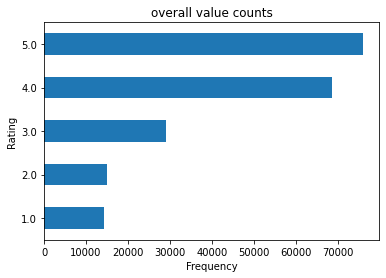

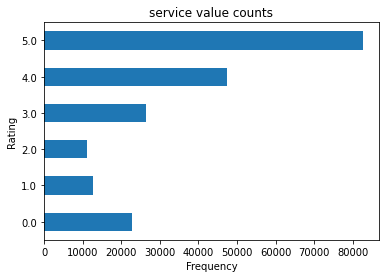

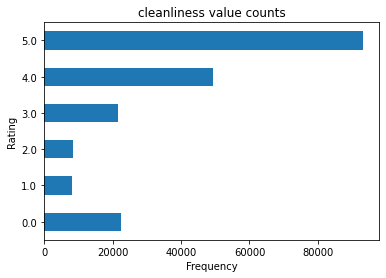

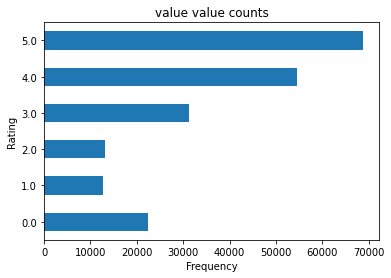

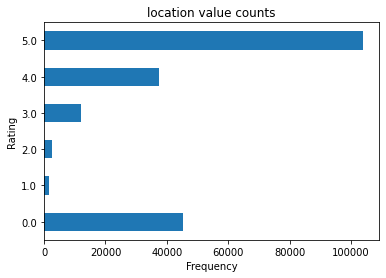

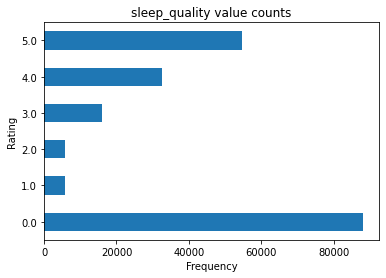

In [40]:
attr = ['overall', 'service', 'cleanliness', 'value', 'location', 'sleep_quality']

for atr in attr:
    plt.title(f"{atr} value counts")
    plt.xlabel('Frequency')
    plt.ylabel('Rating')
    reviews_df[atr].value_counts().sort_index().plot(kind='barh')
    plt.show()

# Tokenization and Model Generation

In [43]:
tf_tokenizer = Tokenizer()
tf_tokenizer.fit_on_texts(X)

## 1. Model Paramteres

In [44]:
text_window = 2000
embedding_dim = 128
lstm_cell_units = 100
batch_size = 256
source_vocab_size = len(tf_tokenizer.word_counts)
epochs = 10
learning_rate = 0.001
dropout_prob = 0.3
cnn1_window = [10]*6
cnn2_window = [5]*6
cnn_filters = 256

## 2. Data generator

In [58]:
class DataGen(Sequence):
    def __init__(self, data, labels, tokenizer, batch_size, text_window):
        self.data = data
        self.labels = labels
        self.tokenzier = tokenizer
        self.batch_size = batch_size
        self.text_window = text_window

    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)

    def __getitem__(self, idx:int):
        batch_data = self.data[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size: (idx+1)*self.batch_size]
        batch_tokens = self.tokenzier.texts_to_sequences(batch_data)
        batch_tokens = pad_sequences(batch_tokens, maxlen=self.text_window, padding='post')

        overall_output = batch_labels[:,0]
        service_output = batch_labels[:,1]
        cleanliness_output = batch_labels[:, 2]
        value_output = batch_labels[:, 3]
        location_output = batch_labels[:, 4]
        sleep_output = batch_labels[:, 5]
        
        return batch_tokens, np.column_stack((overall_output, service_output, cleanliness_output, value_output, location_output, sleep_output))

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [60]:
train_gen = DataGen(X_train, y_train, tf_tokenizer, batch_size, text_window)
test_gen = DataGen(X_test, y_test, tf_tokenizer, batch_size, text_window)

## 3. CNN BiLSTM Model without attention

In [68]:
input_layer = Input(shape=(text_window, ), dtype=tf.int64)

x = Embedding(source_vocab_size+1, embedding_dim, mask_zero=True, name='EmbeddingLayer')(input_layer)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer1'))(x)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer2'))(x)

x = Concatenate(name='Concatenate')([
    GlobalMaxPooling1D(name='Pooling_%i'%i)(
        Conv1D(cnn_filters, cnn2_window[i], name='ConvLayer2_%d'%i)(Conv1D(cnn_filters, cnn1_window[i], name='ConvLayer1_%d'%i)(x))) for i in range(len(cnn1_window))
])

overall_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='OverallLayer')(x))
service_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='ServiceLayer')(x))
cleanliness_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='CleanlinessLayer')(x))
value_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='ValueLayer')(x))
location_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='LocationLayer')(x))
sleep_output_layer = Lambda(tf.expand_dims, arguments={'axis':1})(Dense(6, activation='softmax', name='SleepLayer')(x))

output_layer = Concatenate(axis=1)([overall_output_layer, service_output_layer, cleanliness_output_layer, value_output_layer, location_output_layer, sleep_output_layer])


In [69]:
noAttMod = Model(input_layer, output_layer)
noAttMod.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True, reduction='none'), metrics=['accuracy'])
noAttMod.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 2000, 128)    12759296    ['input_4[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 2000, 200)   183200      ['EmbeddingLayer[0][0]']         
 )                                                                                                
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 2000, 200)   240800      ['bidirectional_6[0][0]']  

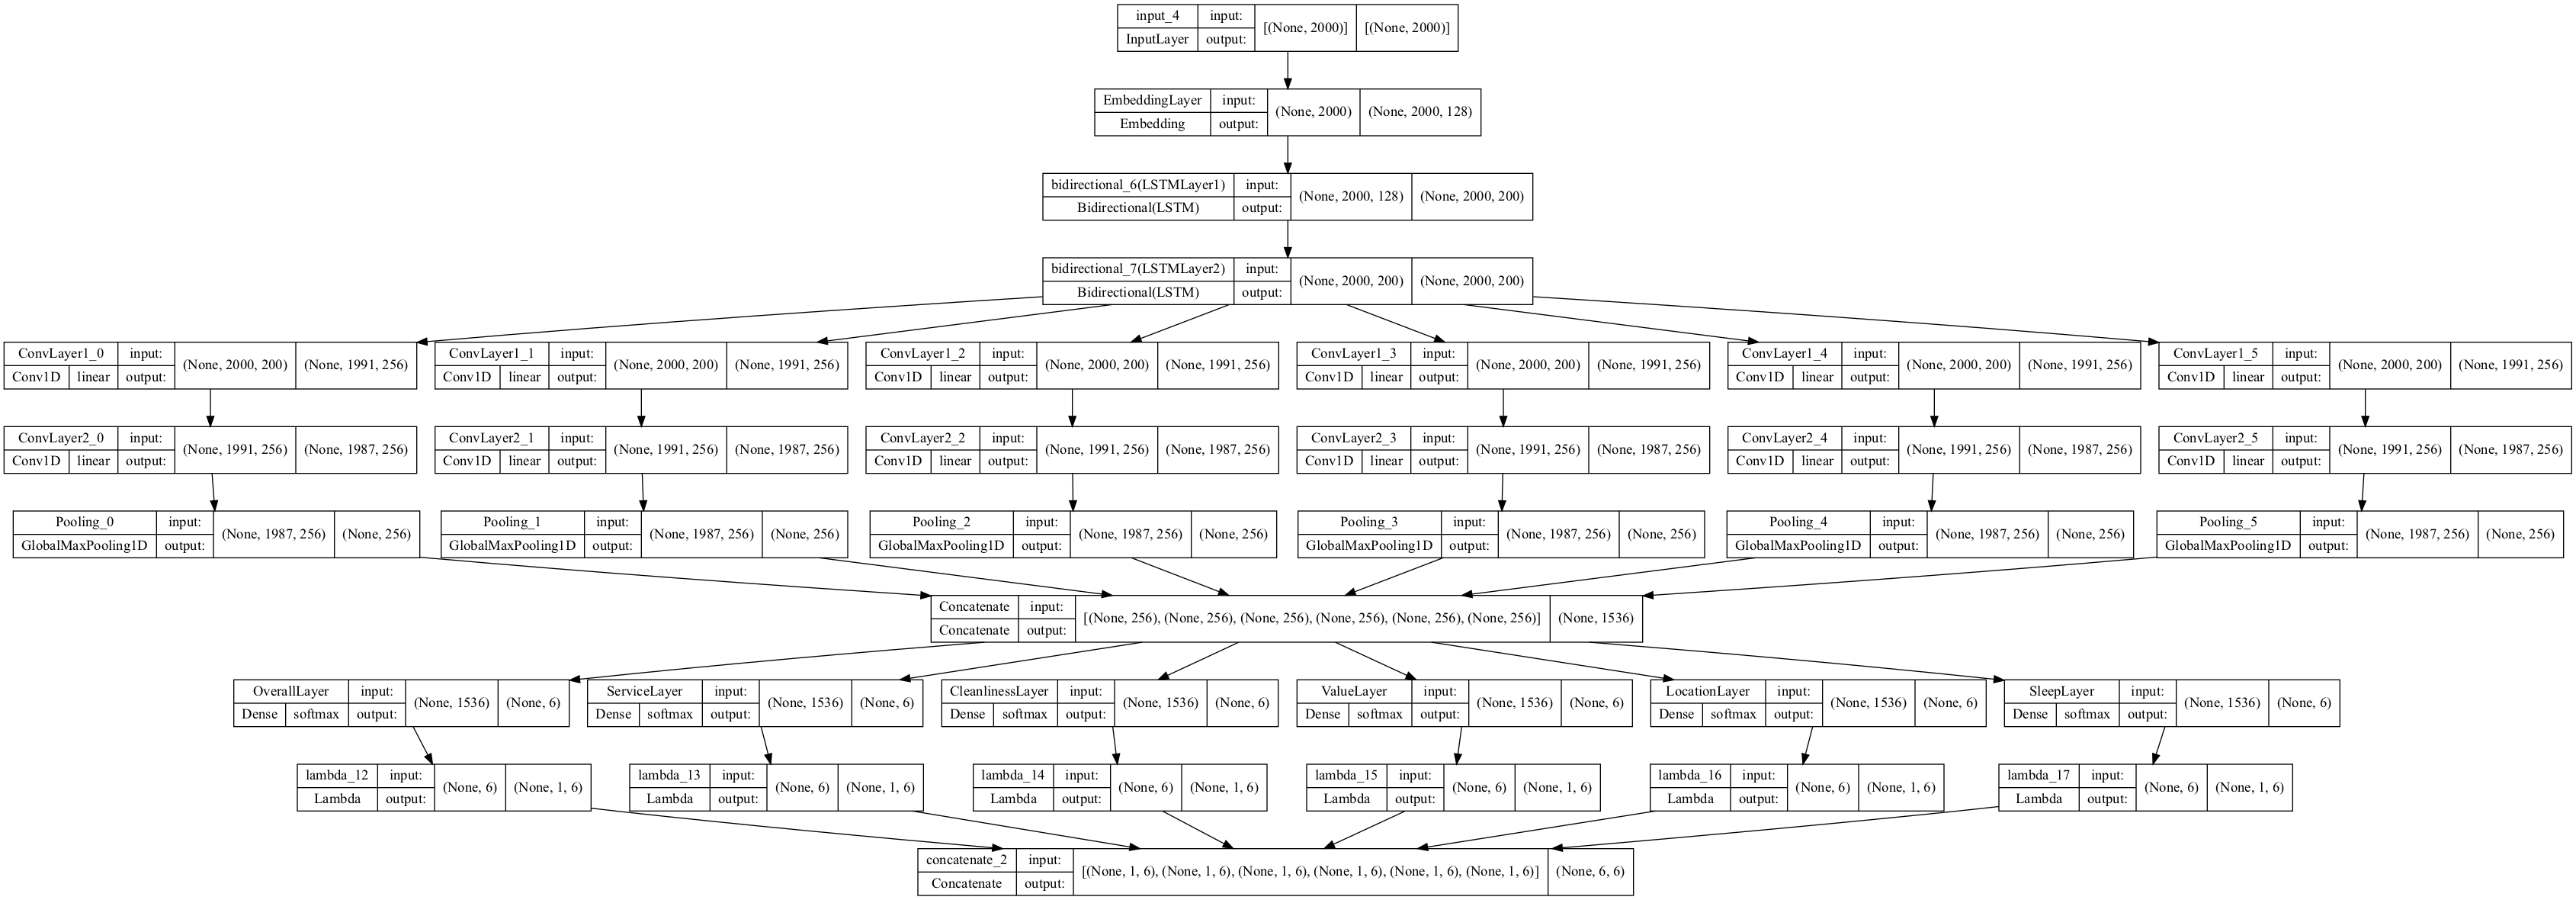

In [70]:
plot_model(noAttMod, "without_attention_model.png", show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [71]:
noAttMod.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=ModelCheckpoint('model', save_best_only=True))

Epoch 1/10


2022-05-10 21:29:38.080852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 21:29:39.959266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 21:29:39.959417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 21:29:59.569152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 21:29:59.749881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 21:30:25.304885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 21:30:29.792025: I tensorflow/core/grappler/optimizers/cust

## 4. CNN BiLSTM Model with attention

In [48]:
class Attention(Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.query_dense_layer = Dense(units, use_bias=False, name='QueryDense')
        self.value_dense_layer = Dense(units, use_bias=False, name='ValueDense')

        self.attention_layer = AdditiveAttention(name='AdditiveAttention')
        
    def call(self, query, value, mask):
        return self.get_stacked_layers(query, value, mask)
    
    def get_stacked_layers(self, query, value, mask):
        query_dense = self.query_dense_layer(query)
        value_dense = self.value_dense_layer(value)

        mask = [
            tf.ones(tf.shape(query)[:-1], dtype=bool),
            mask
        ]
        context_vector, attention_weights = self.attention_layer(
            inputs = [query_dense, value_dense],
            mask = mask,
            return_attention_scores = True
        )
        
        return context_vector, attention_weights

In [49]:
input_layer = Input(shape=(text_window, ), dtype=tf.int64)

x = Embedding(source_vocab_size+1, embedding_dim, mask_zero=True, name='EmbeddingLayer')(input_layer)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer1'))(x)
x = Bidirectional(LSTM(lstm_cell_units, return_state=False, return_sequences=True, name='LSTMLayer2'))(x)

cnn_output = Concatenate(axis=1)([Lambda(tf.keras.backend.expand_dims, arguments={'axis':1})(GlobalMaxPooling1D()(Conv1D(cnn_filters, cnn2_window[i], name='ConvLayer2_%d'%i)
                (Conv1D(cnn_filters, cnn1_window[i], name='ConvLayer1_%d'%i)(x)))) for i in range(len(cnn1_window))])

context, score = Attention(10)(cnn_output, x, x._keras_mask)

x = Concatenate(axis=-1)([cnn_output, context])
output_layer = Dense(6, activation='softmax', name='OutputDenseLayer')(x)


2022-05-10 21:15:08.101560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-10 21:15:08.102261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [50]:
attMod = Model(input_layer, output_layer)

In [51]:
optimizer = Adam(learning_rate)
attMod.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True, reduction='none'), metrics=['accuracy'])
attMod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 2000, 128)    12759296    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 2000, 200)    183200      ['EmbeddingLayer[0][0]']         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 2000, 200)   240800      ['bidirectional[0][0]']          
 )                                                                                            

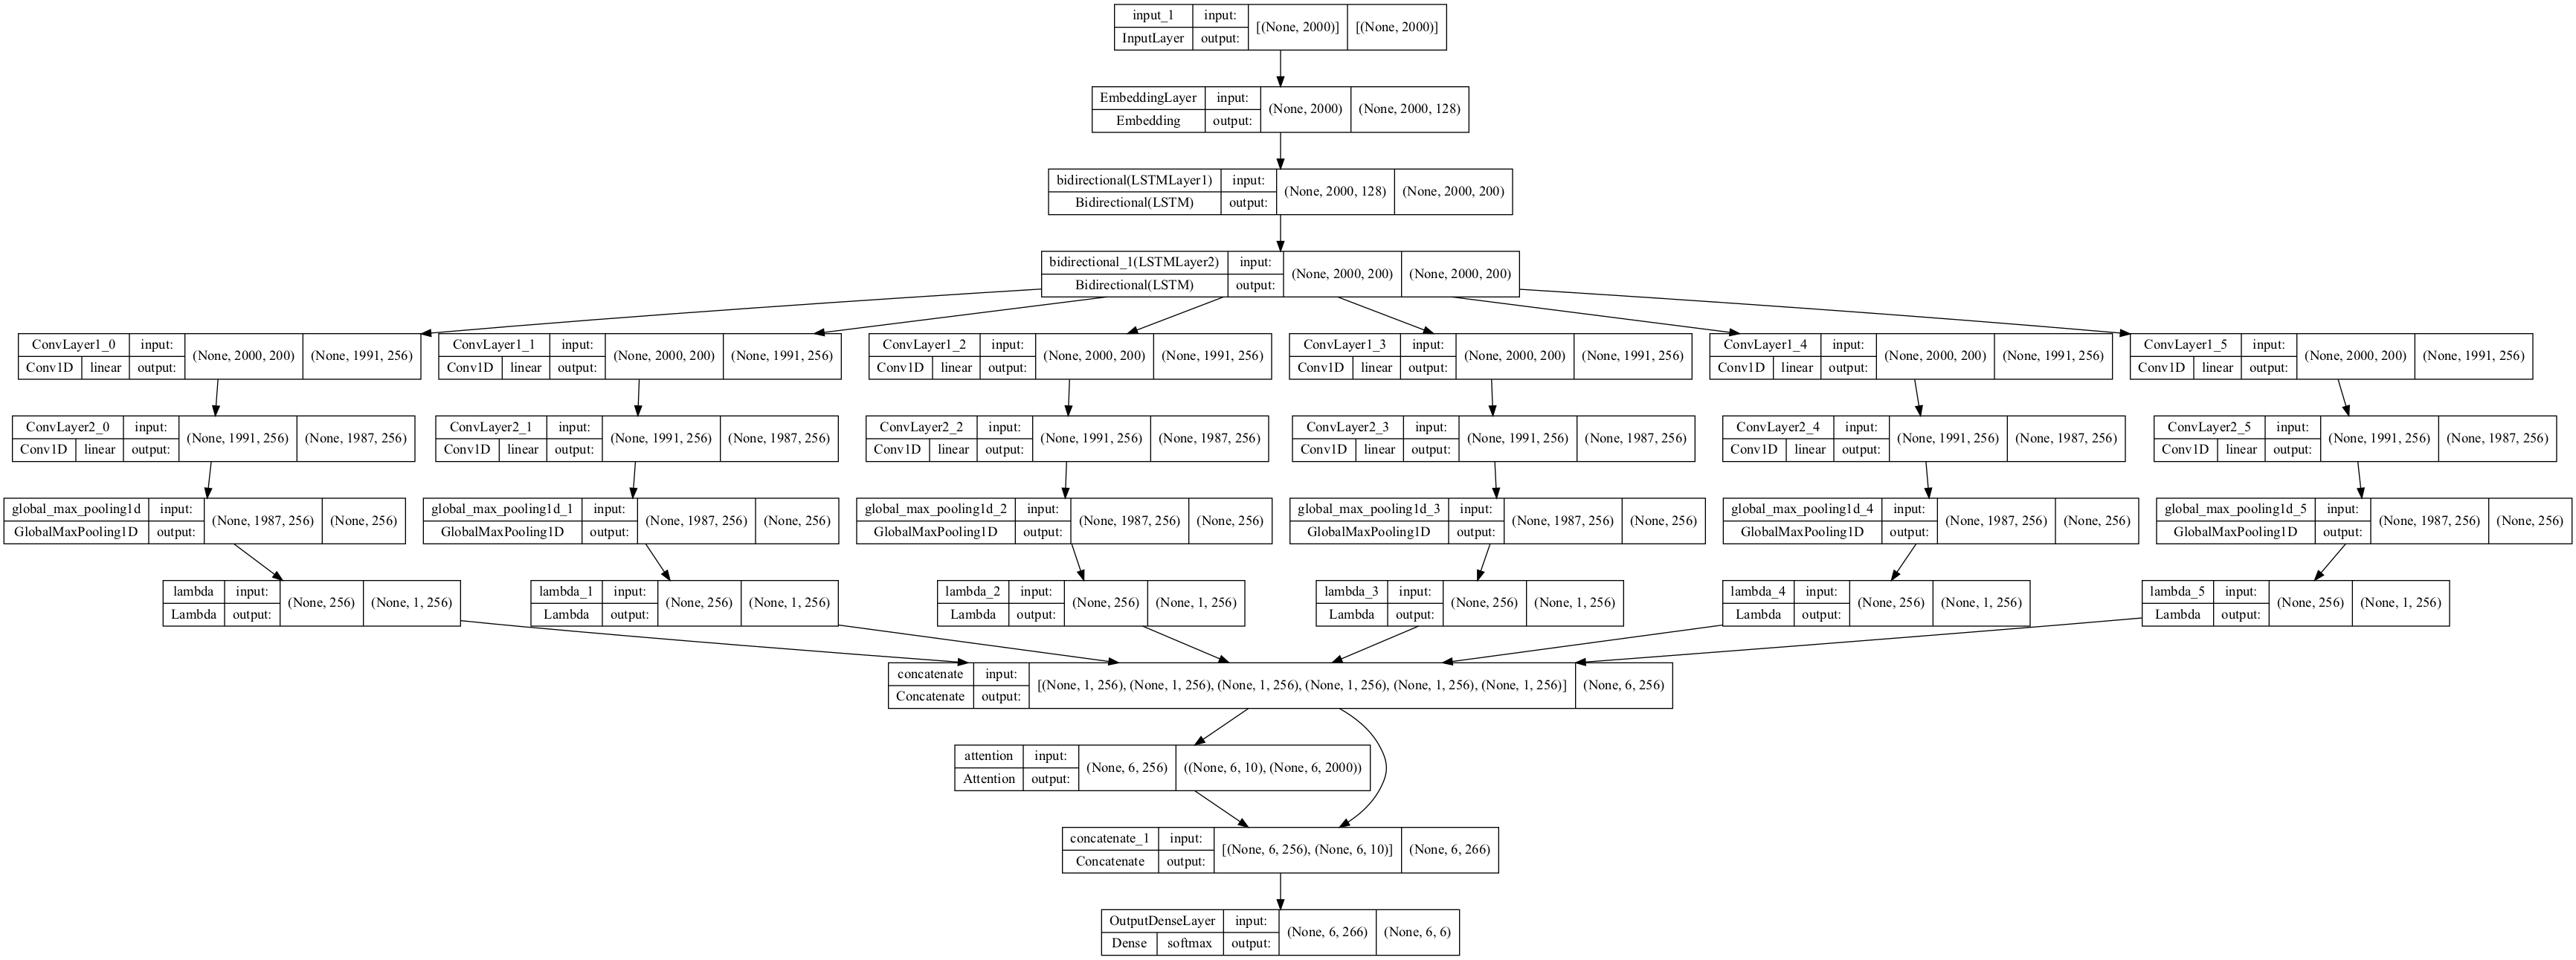

In [52]:
plot_model(attMod, "attention_model.png", show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [54]:
attMod.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=ModelCheckpoint('model', save_best_only=True))

Epoch 1/10


TypeError: in user code:

    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/metrics.py", line 455, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/Users/varunreddy/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_11'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.
